# CLIP Interrogator 2.4 by [@pharmapsychotic](https://twitter.com/pharmapsychotic)

Want to figure out what a good prompt might be to create new images like an existing one? The CLIP Interrogator is here to get you answers!

<br>

For Stable Diffusion 1.X choose the **ViT-L** model and for Stable Diffusion 2.0+ choose the **ViT-H** CLIP Model.

This version is specialized for producing nice prompts for use with Stable Diffusion and achieves higher alignment between generated text prompt and source image. You can try out the old [version 1](https://colab.research.google.com/github/pharmapsychotic/clip-interrogator/blob/v1/clip_interrogator.ipynb) to see how different CLIP models ranks terms.

You can also run this on HuggingFace and Replicate<br>
[![Generic badge](https://img.shields.io/badge/🤗-Open%20in%20Spaces-blue.svg)](https://huggingface.co/spaces/pharma/CLIP-Interrogator) [![Replicate](https://replicate.com/pharmapsychotic/clip-interrogator/badge)](https://replicate.com/pharmapsychotic/clip-interrogator)

<br>

If this notebook is helpful to you please consider buying me a coffee via [ko-fi](https://ko-fi.com/pharmapsychotic) or following me on [twitter](https://twitter.com/pharmapsychotic) for more cool Ai stuff. 🙂

And if you're looking for more Ai art tools check out my [Ai generative art tools list](https://pharmapsychotic.com/tools.html).


In [1]:
#@title Check GPU
!nvidia-smi -L

GPU 0: NVIDIA RTX A2000 Laptop GPU (UUID: GPU-29168892-cfb5-aeac-0f3a-11c8f48180d4)


In [2]:
# !pip install gradio==3.13.0 -q
# !pip install clip-interrogator
# !pip install open_clip_torch

In [3]:
#@title Setup
import os, subprocess

def setup():
    install_cmds = [
        ['pip', 'install', 'gradio'],
        ['pip', 'install', 'open_clip_torch'],
        ['pip', 'install', 'clip-interrogator'],
    ]
    for cmd in install_cmds:
        print(subprocess.run(cmd, stdout=subprocess.PIPE).stdout.decode('utf-8'))

# setup()

In [4]:
caption_model_name = 'blip-large' #@param ["blip-base", "blip-large", "git-large-coco"]
clip_model_name = 'ViT-L-14/openai' #@param ["ViT-L-14/openai", "ViT-H-14/laion2b_s32b_b79k"]

# import gradio as gr
from clip_interrogator import Config, Interrogator
from PIL import Image

config = Config()
config.clip_model_name = clip_model_name
config.caption_model_name = caption_model_name
ci = Interrogator(config)

def image_analysis(image):
    image = image.convert('RGB')
    image_features = ci.image_to_features(image)

    top_mediums = ci.mediums.rank(image_features, 5)
    top_artists = ci.artists.rank(image_features, 5)
    top_movements = ci.movements.rank(image_features, 5)
    top_trendings = ci.trendings.rank(image_features, 5)
    top_flavors = ci.flavors.rank(image_features, 5)

    medium_ranks = {medium: sim for medium, sim in zip(top_mediums, ci.similarities(image_features, top_mediums))}
    artist_ranks = {artist: sim for artist, sim in zip(top_artists, ci.similarities(image_features, top_artists))}
    movement_ranks = {movement: sim for movement, sim in zip(top_movements, ci.similarities(image_features, top_movements))}
    trending_ranks = {trending: sim for trending, sim in zip(top_trendings, ci.similarities(image_features, top_trendings))}
    flavor_ranks = {flavor: sim for flavor, sim in zip(top_flavors, ci.similarities(image_features, top_flavors))}

    return medium_ranks, artist_ranks, movement_ranks, trending_ranks, flavor_ranks


from clip_interrogator import Config, Interrogator

config = Config()
config.clip_model_name = clip_model_name
config.caption_model_name = caption_model_name
ci = Interrogator(config)

def image_to_prompt(image, mode):
    ci.config.chunk_size = 2048 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    ci.config.flavor_intermediate_count = 2048 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    image = Image.open(image_path).convert('RGB')
    # image = image.convert('RGB')
    if mode == 'best':
        return ci.interrogate(image)
    elif mode == 'classic':
        return ci.interrogate_classic(image)
    elif mode == 'fast':
        return ci.interrogate_fast(image)
    elif mode == 'negative':
        return ci.interrogate_negative(image)

image_path2 = 'mounjaro2.png'
image_to_prompt(image_path2, 'fast')


Loading caption model blip-large...
Loading CLIP model ViT-L-14/openai...
Loaded CLIP model and data in 5.99 seconds.
Loading caption model blip-large...
Loading CLIP model ViT-L-14/openai...


OutOfMemoryError: CUDA out of memory. Tried to allocate 146.00 MiB. GPU 0 has a total capacty of 4.00 GiB of which 0 bytes is free. Of the allocated memory 3.38 GiB is allocated by PyTorch, and 20.35 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

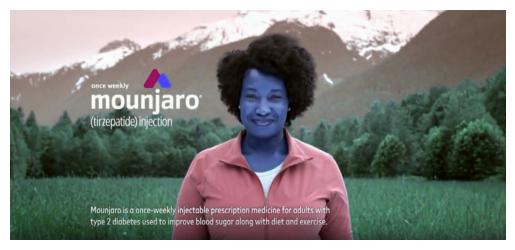

In [7]:
import os
import easyocr
import cv2
from matplotlib import pyplot as plt
import numpy as np

IMAGE_PATH = 'mounjaro1.png'
image_path = 'mounjaro1.png'

IMAGE_PATH2 = 'mounjaro2.png'
image_path2 = 'mounjaro2.png'

image_orignal=cv2.imread(image_path2)
plt.imshow(image_orignal)
plt.axis("off")
plt.show()

In [10]:
image_to_prompt(image_path2,'fast')

AttributeError: 'str' object has no attribute 'convert'

In [12]:
#@title Image to prompt! 🖼️ -> 📝

def prompt_tab():
    with gr.Column():
        with gr.Row():
            image = gr.Image(type='pil', label="Image")
            with gr.Column():
                mode = gr.Radio(['best', 'fast', 'classic', 'negative'], label='Mode', value='best')
        prompt = gr.Textbox(label="Prompt")
    button = gr.Button("Generate prompt")
    button.click(image_to_prompt, inputs=[image, mode], outputs=prompt)

def analyze_tab():
    with gr.Column():
        with gr.Row():
            image = gr.Image(type='pil', label="Image")
        with gr.Row():
            medium = gr.Label(label="Medium", num_top_classes=5)
            artist = gr.Label(label="Artist", num_top_classes=5)
            movement = gr.Label(label="Movement", num_top_classes=5)
            trending = gr.Label(label="Trending", num_top_classes=5)
            flavor = gr.Label(label="Flavor", num_top_classes=5)
    button = gr.Button("Analyze")
    button.click(image_analysis, inputs=image, outputs=[medium, artist, movement, trending, flavor])

with gr.Blocks() as ui:
    with gr.Tab("Prompt"):
        prompt_tab()
    with gr.Tab("Analyze"):
        analyze_tab()

ui.launch(show_api=False, debug=False)


NameError: name 'gr' is not defined

In [ ]:
#@title Batch process a folder of images 📁 -> 📝

#@markdown This will generate prompts for every image in a folder and either save results
#@markdown to a desc.csv file in the same folder or rename the files to contain their prompts.
#@markdown The renamed files work well for [DreamBooth extension](https://github.com/d8ahazard/sd_dreambooth_extension)
#@markdown in the [Stable Diffusion Web UI](https://github.com/AUTOMATIC1111/stable-diffusion-webui).
#@markdown You can use the generated csv in the [Stable Diffusion Finetuning](https://colab.research.google.com/drive/1vrh_MUSaAMaC5tsLWDxkFILKJ790Z4Bl?usp=sharing)

import csv
import os
from IPython.display import clear_output, display
from PIL import Image
from tqdm import tqdm

folder_path = "/content/my_images" #@param {type:"string"}
prompt_mode = 'best' #@param ["best","fast","classic","negative"]
output_mode = 'rename' #@param ["desc.csv","rename"]
max_filename_len = 128 #@param {type:"integer"}


def sanitize_for_filename(prompt: str, max_len: int) -> str:
    name = "".join(c for c in prompt if (c.isalnum() or c in ",._-! "))
    name = name.strip()[:(max_len-4)] # extra space for extension
    return name

ci.config.quiet = True

files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')] if os.path.exists(folder_path) else []
prompts = []
for idx, file in enumerate(tqdm(files, desc='Generating prompts')):
    if idx > 0 and idx % 100 == 0:
        clear_output(wait=True)

    image = Image.open(os.path.join(folder_path, file)).convert('RGB')
    prompt = image_to_prompt(image, prompt_mode)
    prompts.append(prompt)

    print(prompt)
    thumb = image.copy()
    thumb.thumbnail([256, 256])
    display(thumb)

    if output_mode == 'rename':
        name = sanitize_for_filename(prompt, max_filename_len)
        ext = os.path.splitext(file)[1]
        filename = name + ext
        idx = 1
        while os.path.exists(os.path.join(folder_path, filename)):
            print(f'File {filename} already exists, trying {idx+1}...')
            filename = f"{name}_{idx}{ext}"
            idx += 1
        os.rename(os.path.join(folder_path, file), os.path.join(folder_path, filename))

if len(prompts):
    if output_mode == 'desc.csv':
        csv_path = os.path.join(folder_path, 'desc.csv')
        with open(csv_path, 'w', encoding='utf-8', newline='') as f:
            w = csv.writer(f, quoting=csv.QUOTE_MINIMAL)
            w.writerow(['image', 'prompt'])
            for file, prompt in zip(files, prompts):
                w.writerow([file, prompt])

        print(f"\n\n\n\nGenerated {len(prompts)} prompts and saved to {csv_path}, enjoy!")
    else:
        print(f"\n\n\n\nGenerated {len(prompts)} prompts and renamed your files, enjoy!")
else:
    print(f"Sorry, I couldn't find any images in {folder_path}")
